## Reference

数据集介绍：https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

https://en.wikipedia.org/wiki/Vision_transformer

https://www.kaggle.com/szuzhangzhi/vision-transformer-vit-cuda-as-usual

https://www.kaggle.com/stpeteishii/traffic-sign-vision-transformer

https://www.kaggle.com/scratchpad/notebook6acb15ad8f/edit

### Notebooks

https://www.kaggle.com/prashunjha/traffic-sign-using-pytorch

https://www.kaggle.com/pritamaich/traffic-sign-classification-using-cnn

## import packages

In [61]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
import torch.utils.data as data
from torchvision.utils import make_grid
import torch.optim as optim

import matplotlib.pyplot as plt
% matplotlib inline

## import images directly

In [67]:
data_dir = "./data"
c1 = os.listdir(data_dir)
print(c1)

['Test', 'Train.csv', 'test', 'Test.csv', 'train', 'meta', 'Meta', 'Meta.csv', 'Train']


In [68]:
train_data_path = data_dir + "/" + "Train"
classes = os.listdir(train_data_path)
print(classes)

['13', '22', '19', '24', '10', '36', '40', '27', '14', '30', '20', '5', '7', '42', '34', '33', '3', '38', '31', '12', '2', '29', '25', '17', '32', '41', '9', '16', '8', '39', '11', '21', '26', '28', '0', '1', '23', '15', '35', '4', '18', '6', '37']


In [63]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])
# valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [69]:
# train_data_path ="../input/gtsrb-german-traffic-sign/train"
#val_data_path="../input/gtsrb-german-traffic-sign/Test"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=train_tfms)
#val_data=torchvision.datasets.ImageFolder(root=val_data_path,transform=valid_tfms)

Divide a validation set from the train set

In [71]:
val_len = 3000
train_len = len(train_data) - val_len
train_data, val_data = data.random_split(train_data, [train_len, val_len])

In [72]:
BATCH_SIZE = 256
numClasses = 43
train_dl = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_data, batch_size=BATCH_SIZE * 2, num_workers=3, pin_memory=True)

In [73]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [74]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break

In [85]:
# show_batch(train_dl)

In [79]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [77]:
device = get_default_device()
device

device(type='cuda')

In [80]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## dataset from csv (not used)
Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path

https://blog.csdn.net/rosefun96/article/details/87947590?utm_medium=distribute.pc_relevant.none-task-blog-2~default~baidujs_title~default-0.fixedcolumn&spm=1001.2101.3001.4242.1

https://blog.csdn.net/weixin_35338624/article/details/97260217

In [5]:
# class Roi:
#     def __init__(self, X1, Y1, X2, Y2):
#         self.X1 = X1
#         self.Y1 = Y1
#         self.X2 = X2
#         self.Y2 = Y2

In [13]:
# # Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
# class DatasetFromCSV(Dataset):
#     def __init__(self, csv_path):
#         self.data = pd.read_csv(csv_path, iterator=True)
#         self.width = np.asarray(self.data.iloc[:, 0])
#         self.height = np.asarray(self.data.iloc[:, 1])
#         self.roi = Roi(np.asarray(self.data.iloc[:, 2]),
#                        np.asarray(self.data.iloc[:, 3]),
#                        np.asarray(self.data.iloc[:, 4]),
#                        np.asarray(self.data.iloc[:, 5]))
#         self.labels = np.asarray(self.data.iloc[:, 6])
#         self.transforms = transforms.Compose(
#             [transforms.ToTensor(),
#              # transforms.Normalize((0.5,), (0.5,)),
#              ])
#
#     def __getitem__(self, index):  # support int index (from 0 to len(self))
#         single_image_label = self.labels[index]
#         # 读取所有像素值，并将 1D array ([784]) reshape 成为 2D array ([28,28])
#         img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28, 28).astype(float)
#         # 把 numpy array 格式的图像转换成灰度 PIL image
#         img_as_img = Image.fromarray(img_as_np)
#         img_as_img = img_as_img.convert('L')
#         # 将图像转换成 tensor
#         img_as_tensor = self.transforms(img_as_img)
#         # 返回图像及其 label
#         return img_as_tensor, single_image_label
#
#     def __len__(self):
#         return len(self.data.index)

In [ ]:
# batch_size = 64
#
# train_data = DatasetFromCSV('Train.csv')
# test_data = DatasetFromCSV("./data/test.csv")
#
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
#
# img, lab = next(iter(train_loader))
# print(img.shape)

# View the images in the test cases

Notice that the dimensions of the images are not fixed, therefore we need to **resize** the images before model building..

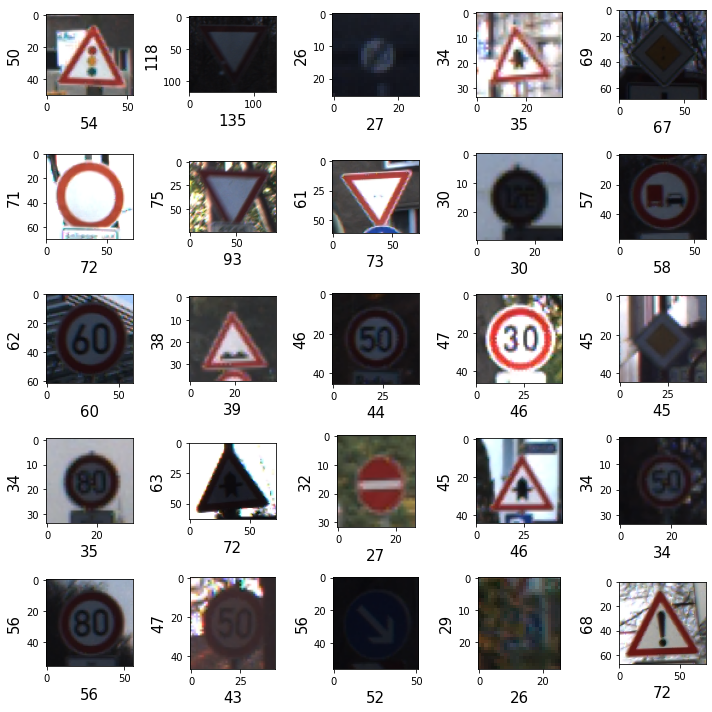

In [53]:
from matplotlib.pyplot import imread
import random

test_path = 'data/Test'
# print(sorted(os.listdir(test_path)))
images_path = os.listdir(test_path)

plt.figure(figsize=(10, 10))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = test_path + '/' + random.choice(images_path)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize=15)  #width of image
    plt.ylabel(rand_img.shape[0], fontsize=15)  #height of image
    plt.tight_layout()
    # plt.show()